In [1]:
using CairoMakie, DelimitedFiles, StatsBase, Base, LinearAlgebra, Distances, LazySets;
include("final_analysis_library.jl");

In [2]:
#simulation params
L = 8
N = 128
M = 100
B = 1;
nu = 0.005;
Delta = 4.;
F0 = 1.; 

K = 4
pk = 0.2

folder = "../data/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B$(B)_L$(L)/half_fixed/long_K$(K)_pk$(pk)/";

sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end];
means = mean(fieldmatrix,dims=1)
dh = fieldmatrix .- means
cij = (dh' * dh)/M
F,V,G = get_FVG(means,cij,L,K)
invflat = get_flatness(Float64.(F),L)[:,1];


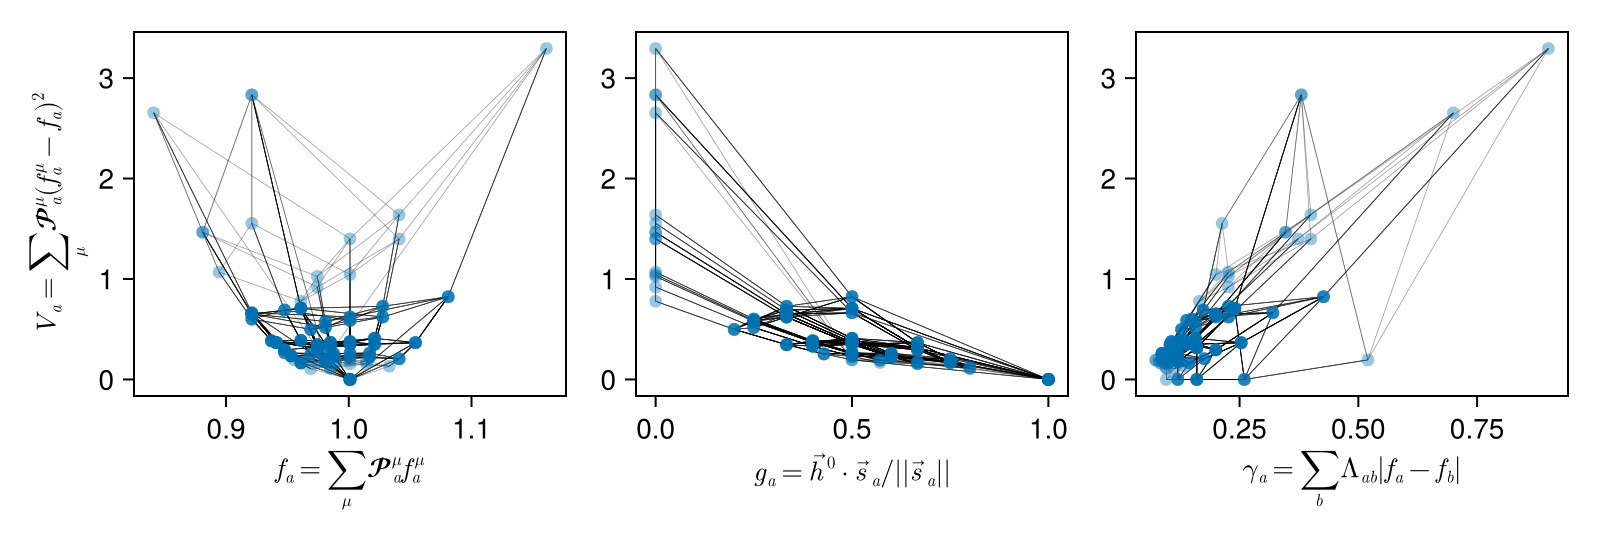

In [3]:
f = Figure(size=(800,270))
pgraph = Axis(f[1,1],xgridvisible = false,ygridvisible = false)
pgen = Axis(f[1,2],xgridvisible = false,ygridvisible = false)
pflat = Axis(f[1,3],xgridvisible = false,ygridvisible = false)
pgraph.xlabel = L"f_a = \sum_\mu \mathcal{P}_a^\mu f_a^\mu"
pgraph.ylabel = L"V_a = \sum_\mu \mathcal{P}_a^\mu (f_a^\mu - f_a)^2"
pgen.xlabel = L"g_a = \vec{h}^0\cdot \vec{s}_a/||\vec{s}_a||"
pflat.xlabel = L"\gamma_a = \sum_b \Lambda_{ab}|f_a-f_b|"
for spec in 0:2^L-1
    seq = digits(spec,base=2,pad=L)
    onehot = Matrix(I, L, L)
    neighs = [(seq .+ onehot[:,k]).%2 for k in 1:L]
    ngh = [bin_to_int(neighs[k]) for k in 1:L]
    for k in 1:L
        lines!(pgraph,[F[spec+1],F[ngh[k]+1]],[V[spec+1],V[ngh[k]+1]],linewidth=0.4,alpha=0.2,color=:black) 
        lines!(pflat,[invflat[spec+1],invflat[ngh[k]+1]],[V[spec+1],V[ngh[k]+1]],linewidth=0.4,alpha=0.2,color=:black)
        lines!(pgen,[G[spec+1],G[ngh[k]+1]],[V[spec+1],V[ngh[k]+1]],linewidth=0.4,alpha=0.2,color=:black) 
    end
end

scatter!(pgraph,F,V,alpha=0.4)
t = map(F, V) do xi, yi
           [xi, yi]
    end;
ch = convex_hull(t)
C = reduce(hcat,ch)

scatter!(pgen,G,V,alpha=0.4)

scatter!(pflat,invflat,V,alpha=0.4)
save("../data/plots/features.pdf",f)
f

correlations between features

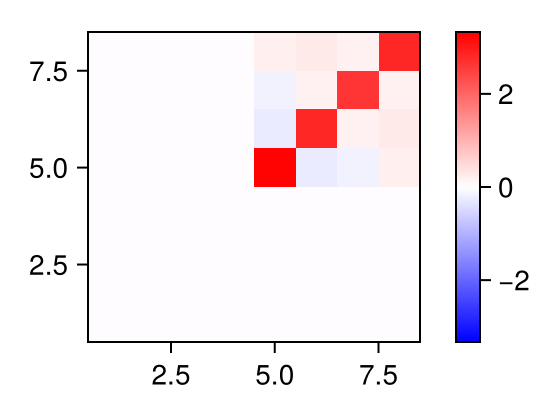

In [24]:
dh = fieldmatrix .- means
cij = (dh' * dh)/M

fig = Figure(size=(280,210))
ax = Axis(fig[1,1])
hm = heatmap!(ax,cij,colormap= "bwr",colorrange=(-maximum(vars),maximum(vars)))
Colorbar(fig[:, end+1], hm)

fig

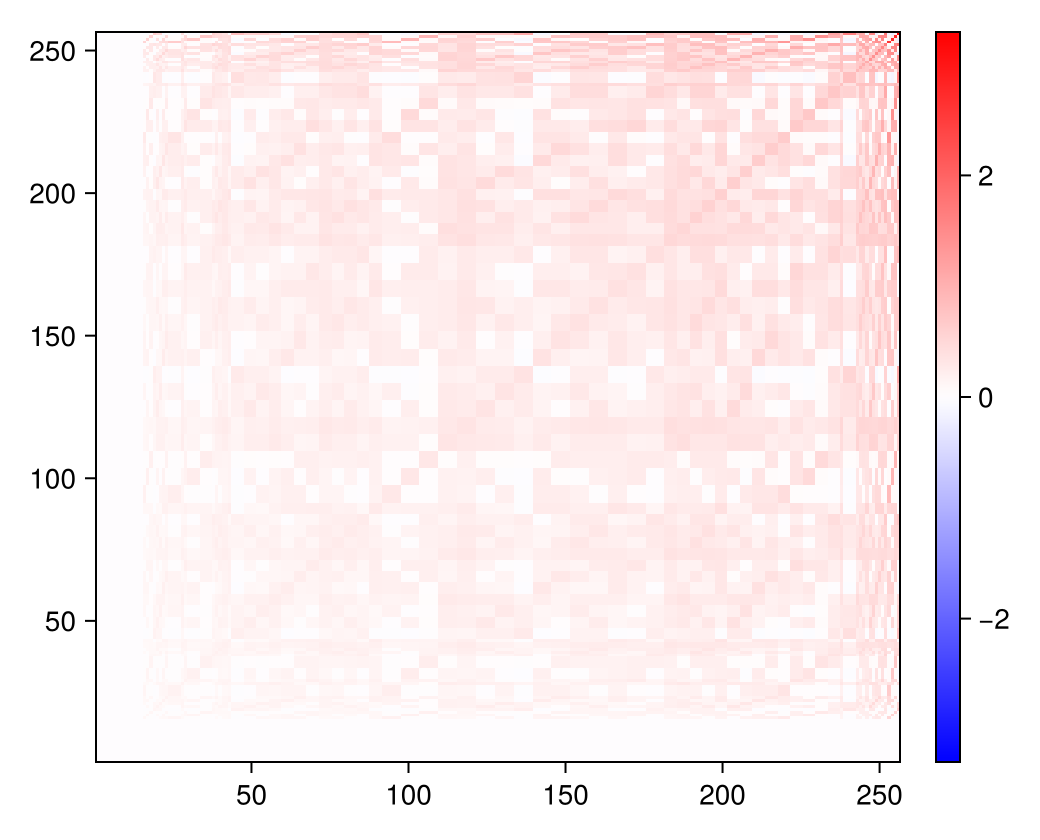

In [25]:
Cmat = ones(2^L,2^L)
for spec1 in 0:2^L-1
    seq1 = digits(spec1,base=2,pad=L)
    norm1 = sum(seq1)
    if norm1==0
        vec1 = ones(L)/L
    else
        vec1 = seq1./norm1 
    end
    for spec2 in 0:spec1
        seq2 = digits(spec2,base=2,pad=L)
        norm2 = sum(seq2)
        if norm2==0
            vec2 = ones(L)/L
        else
            vec2 = seq2./norm2
        end
        @show vec2
        c = vec1'*cij*vec2
        Cmat[spec1+1,spec2+1] = copy(c)
        Cmat[spec2+1,spec1+1] = copy(c)
    end
end

fig = Figure(size=(520,420))
ax = Axis(fig[1,1]) 
ford = sortperm(V)
hm = heatmap!(ax,Cmat[ford,ford],colormap= "bwr",colorrange=(-maximum(Cmat),maximum(Cmat)))

Colorbar(fig[:, end+1], hm)
fig

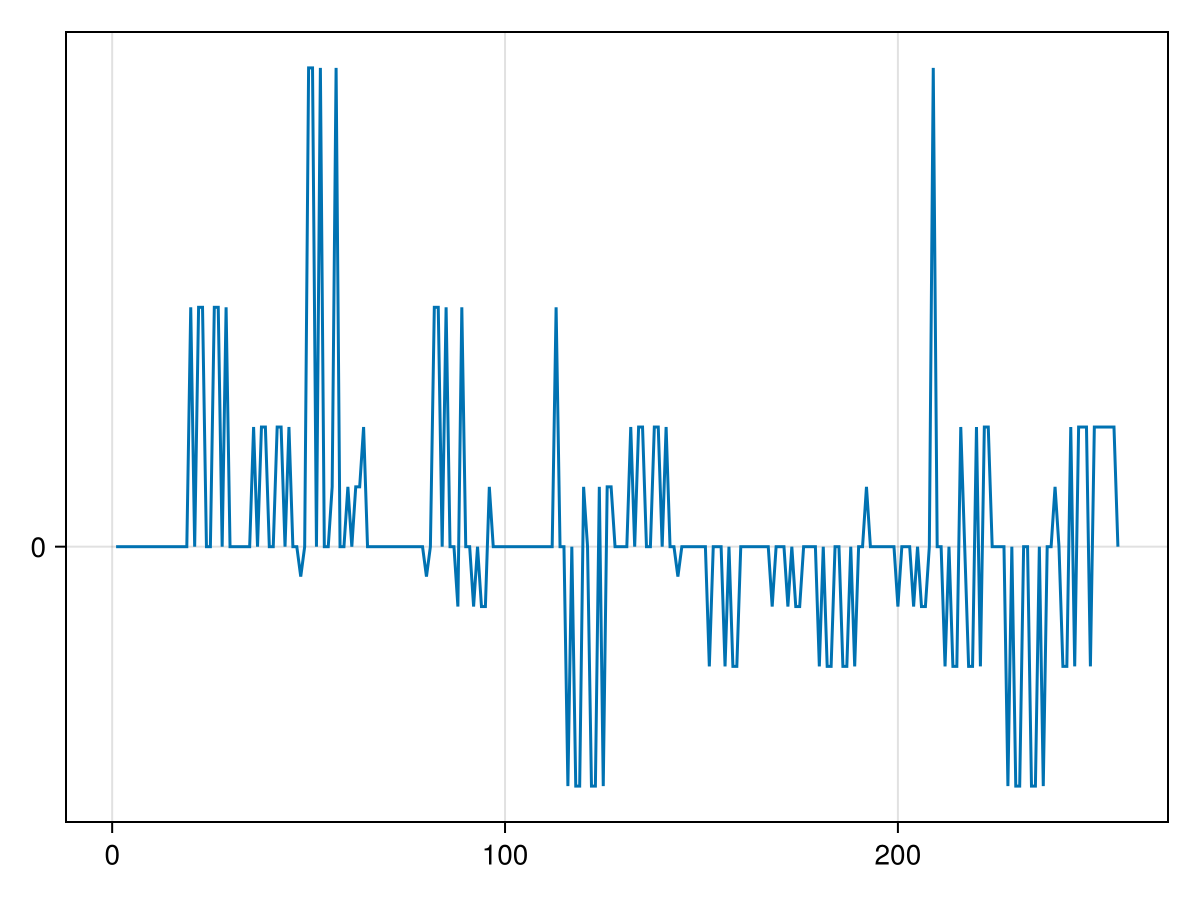

In [26]:
lines(V - diag(Cmat))